In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from IPython.core.display import HTML
from sklearn.metrics import pairwise_distances

from xrun.data.run_info import RunInfo

In [3]:
def load_cost_from_file(file_path: Path):
    if file_path.exists():
            with open(file_path, "r") as f:
                return float(f.read())
    else:
        # print(f"Warning: {file_path} not found!")
        pass
    return None

def get_algorithm_name(run_info):
    if run_info.algorithm == "uniform-sampling":
        return "Uniform Sampling"
    elif run_info.algorithm == "sensitivity-sampling":
        return "Sensitivity Sampling"
    elif run_info.algorithm == "group-sampling":
        return "Group Sampling"
    return "Unknown"

def get_dataset_print_name(run_info):
    d = {
        "census": "Census",
        "covertype": "Covertype",
        "tower": "Tower",
    }
    if run_info.dataset in d:
        return d[run_info.dataset]
    return run_info.dataset
    
def get_costs(file_paths):
    costs = []
    for index, run_file_path in enumerate(file_paths):
        run_info = RunInfo.load_json(run_file_path)
        real_cost = load_cost_from_file(run_file_path.parent / "real_cost.txt")
        coreset_cost = load_cost_from_file(run_file_path.parent / "coreset_cost.txt")
        distortion = load_cost_from_file(run_file_path.parent / "distortion.txt")
        costs.append({
            "dataset": get_dataset_print_name(run_info),
            "algorithm": get_algorithm_name(run_info),
            "k": run_info.k,
            "coreset_size": run_info.m,
            "coreset_size_factor": run_info.m / run_info.k,
            "running_time": int(run_info.duration_secs),
            "real_cost": real_cost,
            "coreset_cost": coreset_cost,
            "distortion": distortion,
            "run_file_path": str(run_file_path),
        })
    df_data = pd.DataFrame(costs)
    return df_data

def aggregate_costs(df_costs: pd.DataFrame):
    group_columns = ["dataset", "algorithm", "k", "coreset_size_factor"]
    df_top_k = df_costs.groupby(group_columns, as_index=False).head(10)
    df_aggr_costs = df_top_k.groupby(group_columns, as_index=False).agg(
        experiment_count=("algorithm", "count"),
        real_cost_mean=("real_cost", "mean"),
        real_cost_std=("real_cost", "std"),
        coreset_cost_mean=("coreset_cost", "mean"),
        coreset_cost_std=("coreset_cost", "std"),
        running_time_mean=("running_time", "mean"),
        running_time_std=("running_time", "std"),
        distortion_mean=("distortion", "mean"),
        distortion_median=("distortion", "median"),
        distortion_std=("distortion", "std"),
        distortion_max=("distortion", "max"),
    )
    df_aggr_costs["running_time"] = pd.to_timedelta(df_aggr_costs.running_time_mean, unit='s')
    df_aggr_costs["running_time_formatted"] = df_aggr_costs["running_time"].map(
        lambda x: f"{x.components.hours:02d}h {x.components.minutes:02d}m {x.components.seconds:02d}s"
    )
    return df_aggr_costs

def add_combined_mean_std(df: pd.DataFrame, attr: str, g_format: bool=False):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        if g_format:
            return f"{mean:.1e} ({std:.1e})"
        else:
            return f"{mean:0.2f} ({std:0.3f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)
    
def get_weights(df_data, dataset: str="Census", k: int=10):
    results = dict()
    algorithms = df_cost_data.algorithm.unique()
    for algo in algorithms:
        f1 = df_data["dataset"] == dataset
        f2 = df_data["algorithm"] == algo
        f3 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3].copy()
        job_info_path = df_filtered.sample(1)["run_file_path"].iloc[0]
        coreset_path = Path(job_info_path).parent / "results.txt.gz"
        print(f"Using experiment: {Path(job_info_path).parent}")
        coreset = np.loadtxt(fname=coreset_path, dtype=np.double, delimiter=' ', skiprows=1)
        coreset_weights = coreset[:,0]
        coreset_points = coreset[:,1:]
        results[algo] = coreset_weights
    return results

In [4]:
run_files = list(Path("../data/experiments-odin/").glob("**/*.json"))
print(f"Number of jobs: {len(run_files)}")

Number of jobs: 1289


In [5]:
df_cost_data = get_costs(run_files)
n_before_filtering = df_cost_data.shape[0]
df_cost_data = df_cost_data.dropna()
df_cost_data = df_cost_data[df_cost_data["coreset_size_factor"] == 200]
n_after_filtering = df_cost_data.shape[0]

print(f"Row size: before={n_before_filtering} after={n_after_filtering}")

Row size: before=1289 after=450


In [6]:
weights_map = get_weights(df_data=df_cost_data, dataset="Tower", k=20)

Using experiment: ../data/experiments-odin/tower/group-sampling-k20-m4000/2022-05-17-06-48-27
Using experiment: ../data/experiments-odin/tower/uniform-sampling-k20-m4000/2022-05-17-12-19-06
Using experiment: ../data/experiments-odin/tower/sensitivity-sampling-k20-m4000/2022-05-17-06-33-14


In [7]:
for algo, weights in weights_map.items():
    print(f"Weight shape:  {algo} {weights.shape}")

Weight shape:  Group Sampling (4036,)
Weight shape:  Uniform Sampling (3998,)
Weight shape:  Sensitivity Sampling (4039,)


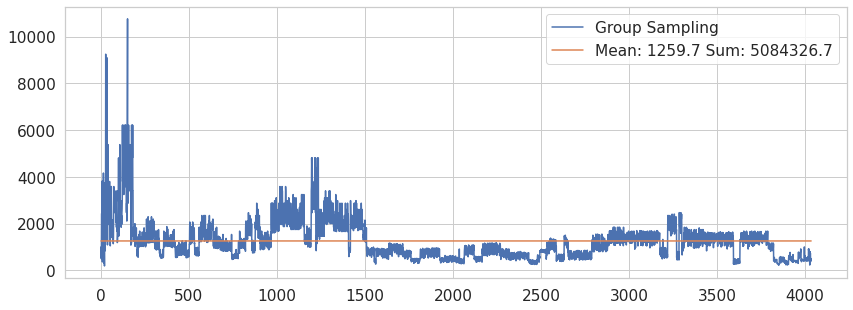

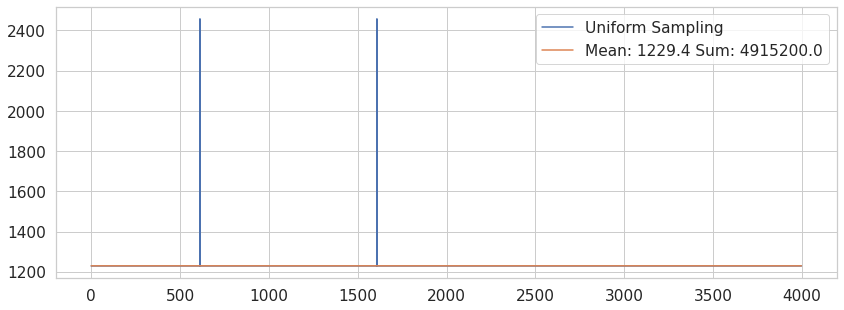

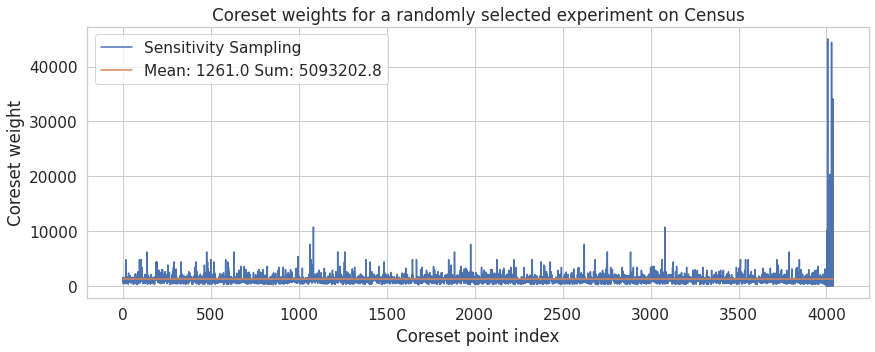

In [8]:
with sns.plotting_context("notebook", font_scale=1.4):
    for algo, coreset_weights in weights_map.items():
        # coreset_weights = reject_outliers(coreset_weights)
        fig, ax = plt.subplots(figsize=(14, 5))
        a = np.arange(coreset_weights.shape[0])
        sns.lineplot(x=a, y=coreset_weights, label=algo, ax=ax)
        sns.lineplot(x=a, y=coreset_weights.mean(), label=f"Mean: {coreset_weights.mean():0.1f} Sum: {coreset_weights.sum():0.1f}", ax=ax)
    # ax.set_yscale("log")
    ax.set_ylabel("Coreset weight")
    ax.set_xlabel("Coreset point index")
    ax.set_title("Coreset weights for a randomly selected experiment on Census")